# Model 1: Random Forest Regression
## Predicting E-commerce Sales Amount (grand_total)

### Objective:
Build a **Random Forest Regressor** to predict the total sales amount (`grand_total`) for each transaction.

### Why Random Forest?
- Handles non-linear relationships well
- Robust to outliers (important for e-commerce data with varying prices)
- No need for feature scaling
- Provides feature importance insights
- Good performance with minimal tuning (perfect for beginners!)

## Step 1: Import Libraries

In [14]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Step 2: Load the Cleaned Data

**Note:** Make sure your cleaned data file named `cleaned_final_data.csv`

In [15]:
# Load the dataset
df = pd.read_csv('cleaned_final_data.csv')


print(f"Dataset Shape: {df.shape}")
print(f"Total Rows: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")

# Display first few rows
df.head()

Dataset Shape: (570901, 21)
Total Rows: 570,901
Total Columns: 21


,item_id,status,created_at,sku,price,qty_ordered,grand_total,increment_id,category_name_1,sales_commission_code,discount_amount,payment_method,working_date,bi_status,mv,year,month,customer_since,m-y,fy,customer_id
0,211131.0,complete,2016-07-01,kreations_yi 06-l,1950.0,1.0,1950.0,100147443,women's fashion,unknown,0.0,cod,2016-07-01,#ref!,"1,950",2016.0,7.0,2016-07-01,2016-07-01,FY17,1.0
1,211133.0,canceled,2016-07-01,kcc_buy 2 frey air freshener & get 1 kasual bo...,240.0,1.0,240.0,100147444,beauty & grooming,unknown,0.0,cod,2016-07-01,gross,240,2016.0,7.0,2016-07-01,2016-07-01,FY17,2.0
2,211134.0,canceled,2016-07-01,ego_up0017-999-mr0,2450.0,1.0,2450.0,100147445,women's fashion,unknown,0.0,cod,2016-07-01,gross,"2,450",2016.0,7.0,2016-07-01,2016-07-01,FY17,3.0
3,211135.0,complete,2016-07-01,kcc_krone deal,360.0,1.0,60.0,100147446,beauty & grooming,r-fsd-52352,300.0,cod,2016-07-01,net,360,2016.0,7.0,2016-07-01,2016-07-01,FY17,4.0
4,211136.0,order_refunded,2016-07-01,bk7010400ag,555.0,2.0,1110.0,100147447,soghaat,unknown,0.0,cod,2016-07-01,valid,"1,110",2016.0,7.0,2016-07-01,2016-07-01,FY17,5.0


## Step 3: Data Preprocessing for Modeling

### Select Features and Target Variable

In [4]:
# Select relevant columns for modeling
# We'll use these features to predict grand_total
feature_columns = [
    'price',
    'qty_ordered',
    'discount_amount',
    'month',
    'category_name_1',
    'payment_method',
    'status'
]

target_column = 'grand_total'

# Create a copy with only needed columns
df_model = df[feature_columns + [target_column]].copy()

# Remove any rows with missing values
df_model = df_model.dropna()

# Check for missing values
print("\nMissing values:")
print(df_model.isnull().sum())

✓ Model dataset shape: (570901, 8)
✓ Features: 7
✓ Target: grand_total

Missing values:
price              0
qty_ordered        0
discount_amount    0
month              0
category_name_1    0
payment_method     0
status             0
grand_total        0
dtype: int64


### Encode Categorical Variables

Random Forest can't work with text data, so we need to convert categorical variables to numbers.

In [5]:
# Initialize label encoders
label_encoders = {}

# Encode categorical columns
categorical_columns = ['category_name_1', 'payment_method', 'status']

for col in categorical_columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    
print("✓ Categorical variables encoded successfully!")
print("\nEncoded Dataset:")
df_model.head()

✓ Categorical variables encoded successfully!

Encoded Dataset:


,price,qty_ordered,discount_amount,month,category_name_1,payment_method,status,grand_total
0,1950.0,1.0,0.0,7.0,14,2,1,1950.0
1,240.0,1.0,0.0,7.0,1,2,0,240.0
2,2450.0,1.0,0.0,7.0,14,2,0,2450.0
3,360.0,1.0,300.0,7.0,1,2,1,60.0
4,555.0,2.0,0.0,7.0,11,2,3,1110.0


## Step 4: Split Data into Training and Testing Sets

We'll use 80% for training and 20% for testing.

In [6]:
# Separate features (X) and target (y)
X = df_model[feature_columns]
y = df_model[target_column]

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print("="*60)
print("DATA SPLIT COMPLETE")
print("="*60)
print(f"Training set size: {X_train.shape[0]:,} samples ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]:,} samples ({(X_test.shape[0]/len(X))*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")
print("="*60)

DATA SPLIT COMPLETE
Training set size: 456,720 samples (80.0%)
Testing set size: 114,181 samples (20.0%)
Number of features: 7


## Step 5: Train the Random Forest Regressor

Now we'll train our model!

In [7]:
# Initialize the Random Forest Regressor
# n_estimators: number of trees in the forest
# random_state: for reproducibility
rf_model = RandomForestRegressor(
    n_estimators=100,      # 100 trees
    random_state=42,       # for reproducible results
    max_depth=20,          # maximum depth of trees
    min_samples_split=10,  # minimum samples to split a node
    n_jobs=-1              # use all CPU cores for faster training
)

print("Training Random Forest Model...")
print("This may take a few minutes...\n")

# Train the model
rf_model.fit(X_train, y_train)

print("="*60)
print("✓ MODEL TRAINED SUCCESSFULLY!")
print("="*60)

Training Random Forest Model...
This may take a few minutes...

✓ MODEL TRAINED SUCCESSFULLY!


## Step 6: Make Predictions

In [8]:
# Make predictions on training and testing sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

print("✓ Predictions completed!")
print(f"\nFirst 10 predictions vs actual values:")
comparison_df = pd.DataFrame({
    'Actual': y_test[:10].values,
    'Predicted': y_test_pred[:10],
    'Difference': y_test[:10].values - y_test_pred[:10]
})
print(comparison_df)

✓ Predictions completed!

First 10 predictions vs actual values:
    Actual     Predicted   Difference
0   1252.7    562.800954   689.899046
1    559.3    882.318678  -323.018678
2   1089.0   1225.502885  -136.502885
3   3767.0   2981.699138   785.300862
4   8500.0   8601.324492  -101.324492
5   4468.5   4993.765791  -525.265791
6    399.0   1882.258464 -1483.258464
7   3048.0   3443.199925  -395.199925
8  24450.0  24447.472166     2.527834
9    388.0    831.675941  -443.675941


## Step 7: Evaluate Model Performance

We'll use these metrics:
- **R² Score**: How well the model explains the variance (closer to 1 is better)
- **RMSE**: Root Mean Squared Error (lower is better)
- **MAE**: Mean Absolute Error (lower is better)

In [9]:
# Calculate metrics for training set
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)

# Calculate metrics for testing set
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)

# Display results
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print("\nTRAINING SET:")
print(f"  R² Score: {train_r2:.4f}")
print(f"  RMSE: {train_rmse:,.2f}")
print(f"  MAE: {train_mae:,.2f}")

print("\nTESTING SET:")
print(f"  R² Score: {test_r2:.4f} ⭐")
print(f"  RMSE: {test_rmse:,.2f}")
print(f"  MAE: {test_mae:,.2f}")
print("="*60)

# Interpretation
print("\n📊 INTERPRETATION:")
print(f"The model explains {test_r2*100:.2f}% of the variance in sales amount.")
print(f"On average, predictions are off by {test_mae:,.2f} units.")

MODEL PERFORMANCE METRICS

TRAINING SET:
  R² Score: 0.9893
  RMSE: 6,353.16
  MAE: 1,609.77

TESTING SET:
  R² Score: 0.9818 ⭐
  RMSE: 7,421.27
  MAE: 1,881.57

📊 INTERPRETATION:
The model explains 98.18% of the variance in sales amount.
On average, predictions are off by 1,881.57 units.


## Step 8: Feature Importance

Let's see which features are most important for predicting sales!

Feature Importance Ranking:
           Feature  Importance
1      qty_ordered    0.928378
0            price    0.060530
2  discount_amount    0.005003
3            month    0.002144
5   payment_method    0.001806
4  category_name_1    0.001403
6           status    0.000736


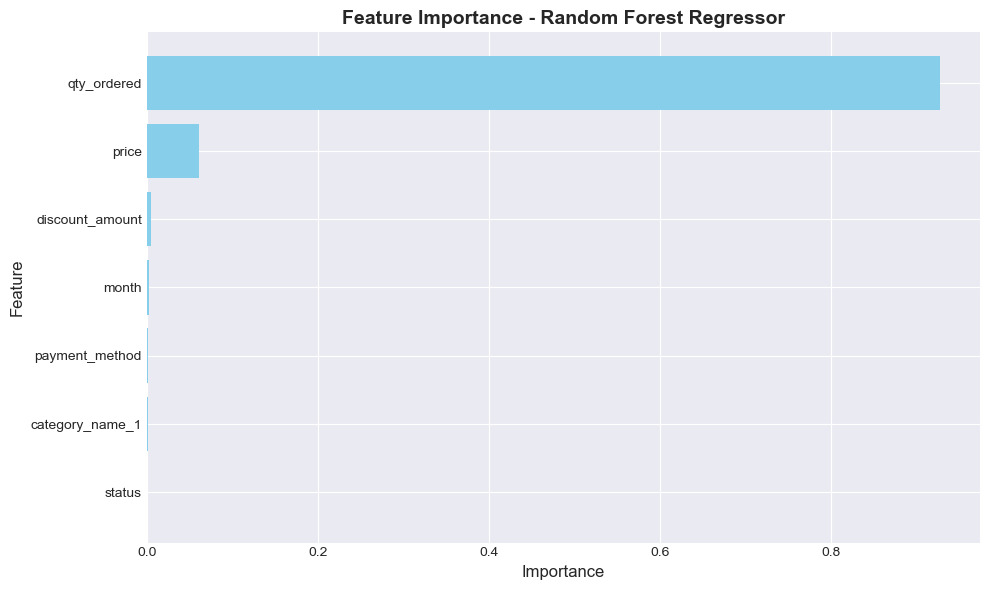


💡 TIP: Higher importance means the feature is more influential in predicting sales!


In [10]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance Ranking:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Random Forest Regressor', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



## Step 9: Visualize Results

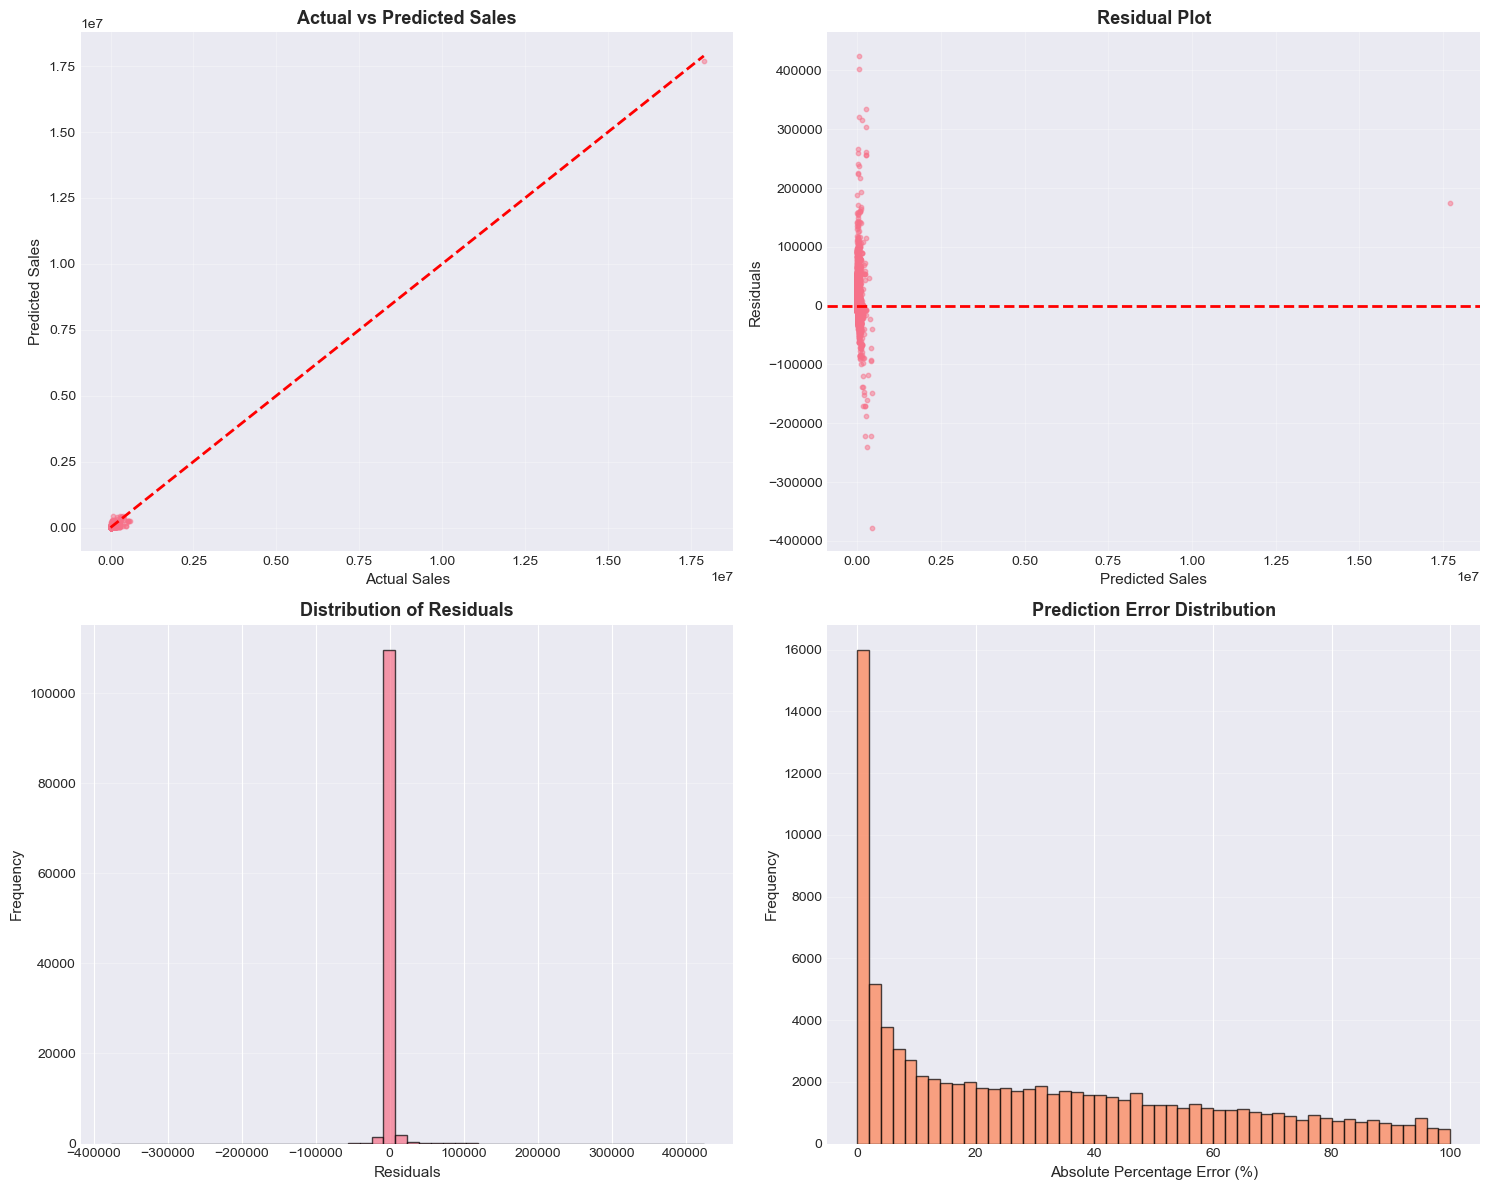

✓ All visualizations generated successfully!


In [11]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (scatter plot)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales', fontsize=11)
axes[0, 0].set_ylabel('Predicted Sales', fontsize=11)
axes[0, 0].set_title('Actual vs Predicted Sales', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Sales', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of residuals
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Prediction Error Distribution
error_percentage = (np.abs(residuals) / y_test) * 100
axes[1, 1].hist(error_percentage[error_percentage < 100], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].set_xlabel('Absolute Percentage Error (%)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Prediction Error Distribution', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ All visualizations generated successfully!")

## Step 10: Save the Model (Optional)

You can save the trained model to use it later without retraining!

In [12]:
import pickle

# Save the model
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Save the label encoders too
with open('label_encoders.pkl', 'wb') as file:
    pickle.dump(label_encoders, file)

print("✓ Model saved successfully!")
print("  - random_forest_model.pkl")
print("  - label_encoders.pkl")
print("\n💡 You can load this model later without retraining!")

✓ Model saved successfully!
  - random_forest_model.pkl
  - label_encoders.pkl

💡 You can load this model later without retraining!


## 🎯 Conclusion

### What We Did:
1. ✅ Loaded and preprocessed the e-commerce dataset
2. ✅ Encoded categorical variables
3. ✅ Split data into training and testing sets
4. ✅ Trained a Random Forest Regressor
5. ✅ Evaluated model performance
6. ✅ Analyzed feature importance
7. ✅ Visualized results
8. ✅ Saved the model for future use

### Key Takeaways:
- Random Forest is great for regression problems with non-linear relationships
- The model can predict sales amounts based on order characteristics
- Feature importance helps us understand what drives sales
- The model can be saved and reused without retraining

### Next Steps:
- Try tuning hyperparameters for better performance
- Experiment with different features
- Compare with other algorithms (see Model 2!)
- Deploy the model for real predictions

---
**Great job! 🎉**